In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install statsmodels

--- Data Analysis (Colab File Input) ---
Upload MAIN dataset (CSV/Excel):


Saving health_care_main_dataset.xlsx to health_care_main_dataset.xlsx
Loaded: health_care_main_dataset.xlsx

Upload SUBSET dataset (CSV/Excel):


Saving health_care_subset_dataset.xlsx to health_care_subset_dataset.xlsx
Loaded: health_care_subset_dataset.xlsx

--- Descriptive Statistics ---

Main Data Stats:
               mean  median   mode        std          var    min    max
Age      49.520000    49.0   26.0  20.929319   438.036388   18.0   85.0
Height  170.160000   170.5  168.0  16.691608   278.609766  140.0  199.0
Weight  106.363333   105.0  104.0  31.753303  1008.272230   50.0  160.0

Subset Data Stats:
               mean  median   mode        std         var    min    max
Age      48.516854    48.0   58.0  20.334203  413.479826   18.0   84.0
Height  171.438202   172.0  172.0  16.420577  269.635342  140.0  198.0
Weight  102.460674   104.0  104.0  30.427655  925.842186   50.0  159.0

Perform T-test or Z-test? ('t-test'/'z-test'/'no'). Significance level (alpha) = 0.05: z-test
Common columns for test: Weight, Age, Height
Enter column(s) to compare (comma-separated, or 'all'): Age

--- Z-TEST Results ---
Z-Test for 'Age': 

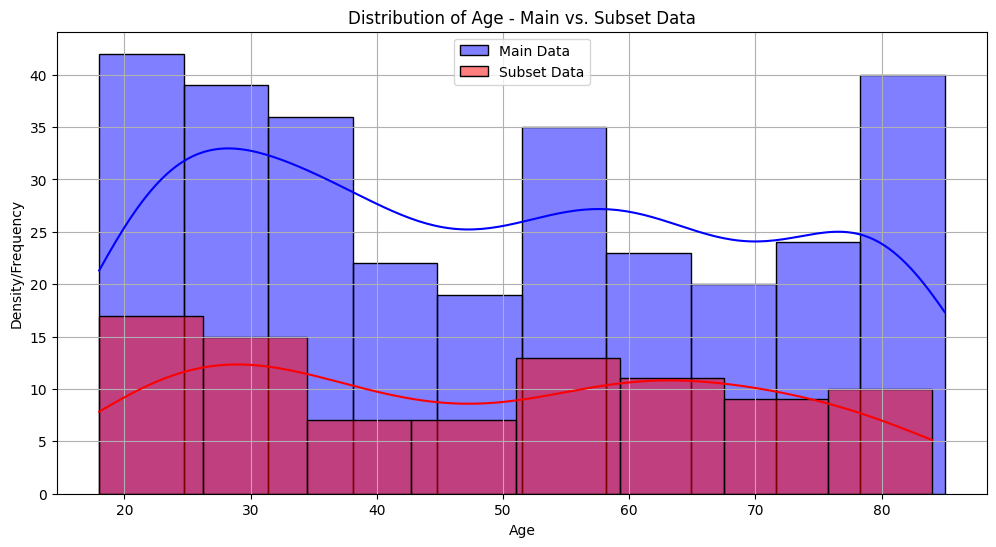


Analysis report saved to 'analysis_report_summary.csv' in Colab session storage.
You can find it in the files sidebar on the left.


In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.weightstats import ztest
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Data Analysis (Colab File Input) ---")
alpha = 0.05

#Predefined Function for Graph Generation ---
def generate_comparison_graphs(df_main, df_subset, col_name):
    print(f"Generating comparative plots for column: '{col_name}'")
    plt.figure(figsize=(12, 6))
    sns.histplot(df_main[col_name].dropna(), kde=True, color='blue', label='Main Data', alpha=0.5)
    sns.histplot(df_subset[col_name].dropna(), kde=True, color='red', label='Subset Data', alpha=0.5)
    plt.title(f'Distribution of {col_name} - Main vs. Subset Data')
    plt.xlabel(col_name)
    plt.ylabel('Density/Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

print("Upload MAIN dataset (CSV/Excel):")
uploaded_main = files.upload()
main_filename = list(uploaded_main.keys())[0]
df_main = pd.read_csv(main_filename) if main_filename.lower().endswith('.csv') else pd.read_excel(main_filename)
print(f"Loaded: {main_filename}")


print("\nUpload SUBSET dataset (CSV/Excel):")
uploaded_subset = files.upload()
subset_filename = list(uploaded_subset.keys())[0]
df_subset = pd.read_csv(subset_filename) if subset_filename.lower().endswith('.csv') else pd.read_excel(subset_filename)
print(f"Loaded: {subset_filename}")


print("\n--- Descriptive Statistics ---")
num_cols_main = df_main.select_dtypes(include=np.number)
num_cols_subset = df_subset.select_dtypes(include=np.number)
main_stats_df = pd.DataFrame()
if not num_cols_main.empty:
    main_stats_df = num_cols_main.agg([
        'mean', 'median',
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'std', 'var', 'min', 'max'
    ]).rename(index={'<lambda>': 'mode'}).T
    print("\nMain Data Stats:\n", main_stats_df)
subset_stats_df = pd.DataFrame()
if not num_cols_subset.empty:
    subset_stats_df = num_cols_subset.agg([
        'mean', 'median',
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'std', 'var', 'min', 'max'
    ]).rename(index={'<lambda>': 'mode'}).T
    print("\nSubset Data Stats:\n", subset_stats_df)
all_stats_df = pd.concat([main_stats_df, subset_stats_df])


test_choice = input(f"\nPerform T-test or Z-test? ('t-test'/'z-test'/'no'). Significance level (alpha) = {alpha}: ").lower()
test_results_list = []
cols_to_test = []
if test_choice in ['t-test', 'z-test']:
    common_cols = list(set(num_cols_main.columns) & set(num_cols_subset.columns))
    if not common_cols:
        print("No common numeric columns for testing.")
    else:
        print(f"Common columns for test: {', '.join(common_cols)}")
        cols_input = input("Enter column(s) to compare (comma-separated, or 'all'): ")
        cols_to_test = common_cols if cols_input.lower() == 'all' else [c.strip() for c in cols_input.split(',') if c.strip() in common_cols]
        if not cols_to_test:
            print("No valid columns selected.")
        else:
            print(f"\n--- {test_choice.upper()} Results ---")
            for col in cols_to_test:
                data_main = df_main[col].dropna()
                data_subset = df_subset[col].dropna()
                result_msg = ""
                significance = "N/A"
                if data_main.empty or data_subset.empty:
                    result_msg = f"Insufficient data in '{col}' for test."
                elif test_choice == 't-test':
                    stat, p_val = stats.ttest_ind(data_main, data_subset, equal_var=True)
                    result_msg = f"T-Test for '{col}': Statistic={stat:.4f}, P-value={p_val:.4f}"
                    significance = "Statistically Significant" if p_val <= alpha else "Not Statistically Significant"
                elif test_choice == 'z-test':
                    stat, p_val = ztest(data_main, data_subset, value=0)
                    result_msg = f"Z-Test for '{col}': Statistic={stat:.4f}, P-value={p_val:.4f}"
                    significance = "Statistically Significant" if p_val <= alpha else "Not Statistically Significant"
                print(result_msg + f" ({significance})")
                test_results_list.append({
                    'Test Type': test_choice.upper(),
                    'Column': col,
                    'Statistic': f"{stat:.4f}" if 'stat' in locals() else "N/A",
                    'P-value': f"{p_val:.4f}" if 'p_val' in locals() else "N/A",
                    'Significance (alpha=0.05)': significance,
                    'Result_Message': result_msg
                })
else:
    print("Skipping statistical tests.")


print("\n--- Generating Comparative Visualizations ---")
if cols_to_test:
    for col in cols_to_test:
        generate_comparison_graphs(df_main, df_subset, col)
else:
    print("No columns were selected for testing, skipping graph generation.")


output_filename = "analysis_report_summary.csv"
with open(output_filename, 'w', newline='') as f:
    f.write("--- Descriptive Statistics ---\n")
    all_stats_df.to_csv(f, index=True, header=True)
    f.write("\n\n")
if test_results_list:
    with open(output_filename, 'a', newline='') as f:
        f.write(f"--- {test_choice.upper()} Results (Alpha = {alpha}) ---\n")
        pd.DataFrame(test_results_list).to_csv(f, index=False, header=True)
print(f"\nAnalysis report saved to '{output_filename}' in Colab session storage.")
print("You can find it in the files sidebar on the left.")

In [ ]:
files.download('analysis_report_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>